<a href="https://colab.research.google.com/github/nicoeiris11/boston-pytorch-regr/blob/master/PyTorch_Boston_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import pandas as pd
from torch.utils.data import DataLoader

In [2]:
random_seed = 43

In [3]:
np.random.seed(random_seed)
random.seed(random_seed)

## Cargar Dataset
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [4]:
bos = load_boston()
bos.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [5]:
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df['Price'] = bos.target
df = df.astype(float)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
y = df['Price'].to_numpy()

In [8]:
# MinMax Scaling of features
scaler = MinMaxScaler()
x = df.drop('Price', axis=1)
x = scaler.fit_transform(x)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_seed)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_seed)

In [11]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

In [12]:
train_data = []
for i in range(len(x_train)):
  train_data.append([x_train[i].numpy(), y_train[i].numpy()])

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

In [13]:
next(iter(train_dataloader))

[tensor([[9.2132e-04, 1.2500e-01, 2.7163e-01, 0.0000e+00, 2.8601e-01, 4.6963e-01,
          6.5602e-01, 4.0292e-01, 1.7391e-01, 2.3664e-01, 2.7660e-01, 9.9672e-01,
          2.9525e-01],
         [5.1208e-04, 0.0000e+00, 1.4773e-01, 0.0000e+00, 1.3169e-01, 4.7021e-01,
          4.3460e-01, 2.9987e-01, 8.6957e-02, 1.1450e-01, 6.2766e-01, 9.9771e-01,
          3.0712e-01],
         [1.4929e-03, 0.0000e+00, 1.3160e-01, 0.0000e+00, 2.5720e-01, 3.8532e-01,
          8.8157e-01, 1.3336e-01, 1.7391e-01, 2.0802e-01, 4.2553e-01, 1.0000e+00,
          3.5762e-01],
         [2.6447e-04, 0.0000e+00, 6.3050e-02, 0.0000e+00, 1.5021e-01, 5.4972e-01,
          5.7467e-01, 4.4854e-01, 8.6957e-02, 6.6794e-02, 6.4894e-01, 9.9299e-01,
          9.6026e-02],
         [1.0538e-03, 0.0000e+00, 7.3314e-02, 0.0000e+00, 2.1193e-01, 5.7521e-01,
          9.5469e-01, 1.5617e-01, 8.6957e-02, 1.1450e-02, 5.5319e-01, 1.0000e+00,
          1.0900e-01],
         [1.1731e-03, 0.0000e+00, 4.9230e-01, 1.0000e+00, 3.3951e

## Definición del Modelo

En esta sección:
- Definiremos una clase que defina la arquitectura de nuestra red.
- En el constructor crearemos las distintas capas
- En el forward pass las conectaremos

In [14]:
class FeedForward(nn.Module):

    def __init__(self, input_size):
      super(FeedForward, self).__init__()
      self.linear1 = nn.Linear(in_features= input_size, out_features=55)
      self.linear2 = nn.Linear(in_features= 55, out_features=23)
      self.output = nn.Linear(in_features= 23, out_features= 1)

    def forward(self, input):
      result = F.relu(self.linear1(input))
      result = F.relu(self.linear2(result))
      output = self.output(result)
      return output

## Crear Modelo

En esta sección:
- Instanciar un modelo
- Instanciar la función de loss
- Instanciar un optimizador

In [15]:
model = FeedForward(13)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

## Entrenamiento

En esta sección:
- Poner el modelo en modo train
- Escribir un loop de entrenamiento hasta que haga overfitting
- Probar técnicas para mejorar el entrenamiento

In [20]:
epoch = 1000
history_train_mean = []
history_val = []

for epoch in range(epoch):
    model.train()
    epoch_loss = []

    for idx, batch in enumerate(train_dataloader):
      optimizer.zero_grad()

      y_pred = model(batch[0]).squeeze()

      loss = criterion(y_pred, batch[1])
      epoch_loss.append(loss.item())

      loss.backward()
      optimizer.step()

    history_train_mean.append(np.mean(epoch_loss))

    model.eval()

    with torch.no_grad():
      y_pred = model(x_val).squeeze()
      after_val = criterion(y_pred, y_val)
      history_val.append(after_val.item())

Pre Optim: 6.967527259479869

In [21]:
print(history_train_mean[len(history_train_mean) - 1]) # Post Optim

4.569143067706715


## Plot Loss

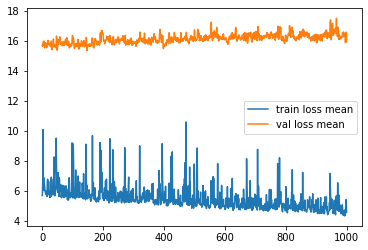

In [22]:
plt.plot(history_train_mean, label='train loss mean')
plt.plot(history_val, label='val loss mean')
plt.legend()

## Evaluar loss en todo Test 

In [23]:
model.eval()
y_pred = model(x_test).squeeze()
test_loss = criterion(y_pred, y_test)
print("Test loss: ", test_loss.item())

Test loss:  7.659366607666016
